# Train / validation / test splitting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx
import pygrts

import df_utils

/Users/jordangraesser/.pyenv/versions/3.8.14/envs/venv.crop_type/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Create fake sample points

In [2]:
rng = np.random.default_rng(100)

In [3]:
num_samples = 1_000
sparse = np.c_[
    rng.uniform(low=-90, high=-88, size=num_samples),
    rng.uniform(low=44, high=46, size=num_samples),
]
dense = np.c_[
    rng.uniform(low=-88.7, high=-88.5, size=int(num_samples * 0.25)),
    rng.uniform(low=44.5, high=45, size=int(num_samples * 0.25)),
]
data = np.vstack((sparse, dense))

In [4]:
df = df_utils.frame_from_coords(data)

---

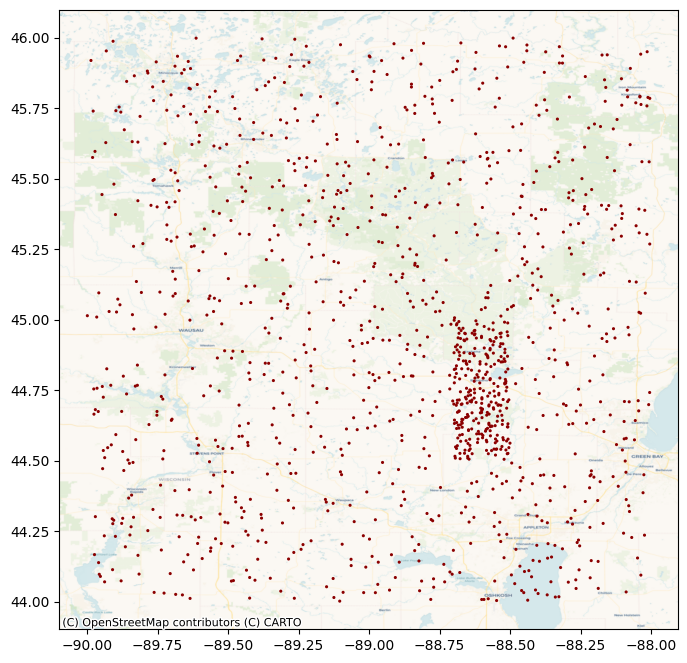

In [5]:
ax = df.plot(color="darkred", ec="none", markersize=5, figsize=(7, 10))
cx.add_basemap(
    ax,
    crs=df.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=10,
)
plt.tight_layout()

# Spatially-balanced splits

In [6]:
df = df.to_crs("epsg:8858")

In [7]:
qt = pygrts.QuadTree(df, force_square=True)

In [8]:
qt.split_recursive(max_length=5_000)

### GRTS sample grids

/var/folders/9h/nb9mkr_j1gq1kmpq663b4myw0000gp/T/ipykernel_10756/2696163038.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


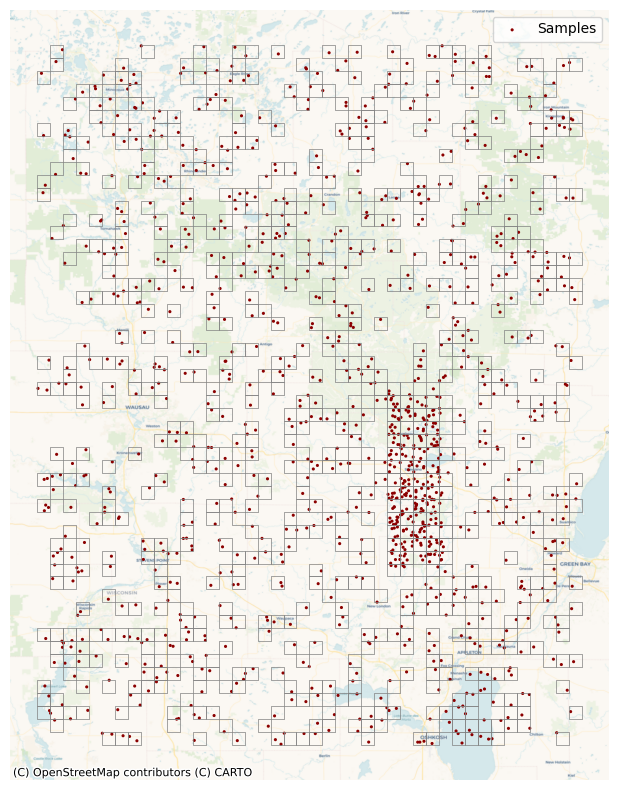

In [9]:
fig, ax = plt.subplots(figsize=(7, 8), dpi=100)

df.plot(color="darkred", ec="none", markersize=5, label="Samples", legend=True, ax=ax)
qt.to_frame().plot(color="none", ec="grey", lw=0.5, label="GRTS grid", ax=ax)
cx.add_basemap(
    ax,
    crs=df.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=10,
)
ax.legend()
ax.axis("off")
plt.tight_layout()

### Split grids into train/validation/test

In [10]:
splits = qt.sample_train_val_test(
    test_frac=0.1,
    val_frac=0.1,
    train_frac=1.0,
    random_state=100,
)

### Plot grid splits

/var/folders/9h/nb9mkr_j1gq1kmpq663b4myw0000gp/T/ipykernel_10756/3959997172.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


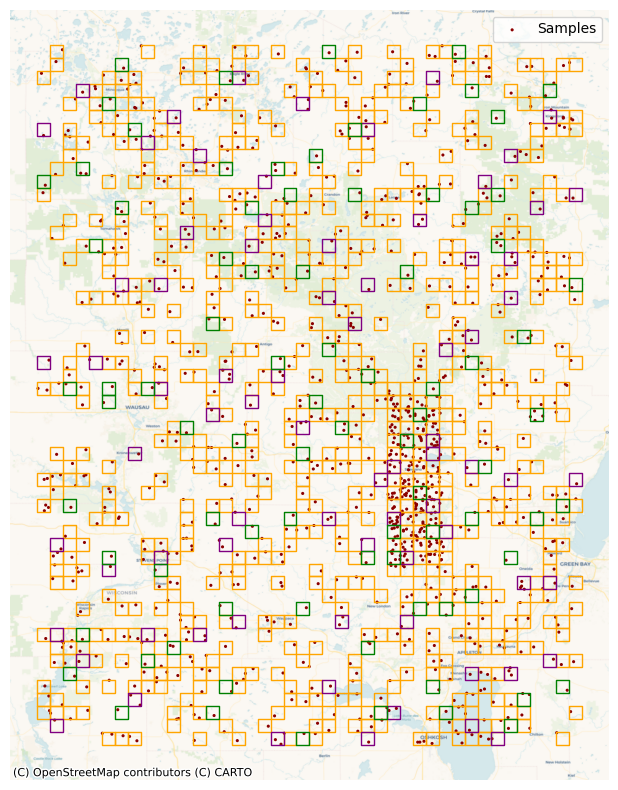

In [11]:
fig, ax = plt.subplots(figsize=(7, 8), dpi=100)

df.plot(color="darkred", ec="none", markersize=5, label="Samples", legend=True, ax=ax)

splits.train.grid_df.plot(color="none", ec="orange", lw=1, label="Train", ax=ax)
splits.val.grid_df.plot(color="none", ec="purple", lw=1, label="Validation", ax=ax)
splits.test.grid_df.plot(color="none", ec="green", lw=1, label="Test", ax=ax)

cx.add_basemap(
    ax,
    crs=df.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=10,
)
ax.legend()
ax.axis("off")
plt.tight_layout()

### Plot sample splits

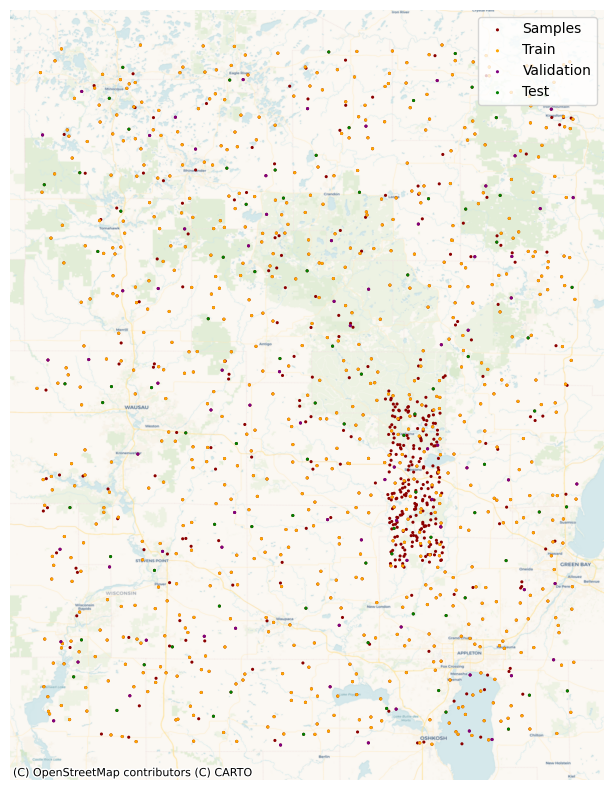

In [12]:
fig, ax = plt.subplots(figsize=(7, 8), dpi=100)

df.plot(color="darkred", ec="none", markersize=5, label="Samples", legend=True, ax=ax)

splits.train.point_df.plot(color="orange", ec="none", markersize=5, label="Train", ax=ax)
splits.val.point_df.plot(color="purple", ec="none", markersize=5, label="Validation", ax=ax)
splits.test.point_df.plot(color="green", ec="none", markersize=5, label="Test", ax=ax)

cx.add_basemap(
    ax,
    crs=df.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=10,
)
ax.legend()
ax.axis("off")
plt.tight_layout()

Note that only a single sample was selected from each grid.

### Get all samples from the grid splits

In [13]:
print('Train:', 'Single sample per grid=', len(splits.train.point_df), 'All samples=', len(df.sjoin(splits.train.grid_df, predicate='within')))

Train: Single sample per grid= 694 All samples= 1002


In [14]:
print('Validation:', 'Single sample per grid=', len(splits.val.point_df), 'All samples=', len(df.sjoin(splits.val.grid_df, predicate='within')))

Validation: Single sample per grid= 77 All samples= 133


In [15]:
print('Test:', 'Single sample per grid=', len(splits.test.point_df), 'All samples=', len(df.sjoin(splits.test.grid_df, predicate='within')))

Test: Single sample per grid= 85 All samples= 115


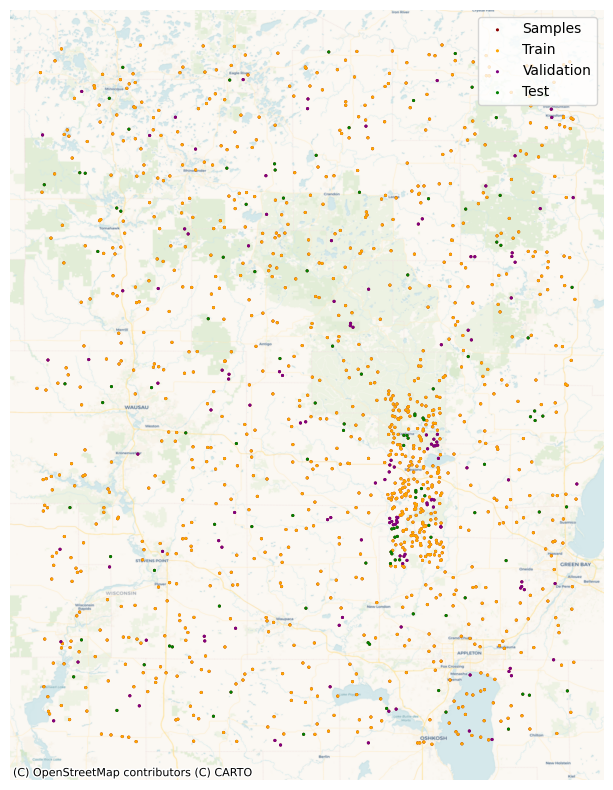

In [16]:
fig, ax = plt.subplots(figsize=(7, 8), dpi=100)

df.plot(color="darkred", ec="none", markersize=5, label="Samples", legend=True, ax=ax)

df.sjoin(splits.train.grid_df, predicate='within').plot(color="orange", ec="none", markersize=5, label="Train", ax=ax)
df.sjoin(splits.val.grid_df, predicate='within').plot(color="purple", ec="none", markersize=5, label="Validation", ax=ax)
df.sjoin(splits.test.grid_df, predicate='within').plot(color="green", ec="none", markersize=5, label="Test", ax=ax)

cx.add_basemap(
    ax,
    crs=df.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=10,
)
ax.legend()
ax.axis("off")
plt.tight_layout()

---

### k-fold cross-validstion splits

/var/folders/9h/nb9mkr_j1gq1kmpq663b4myw0000gp/T/ipykernel_10756/2141700166.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


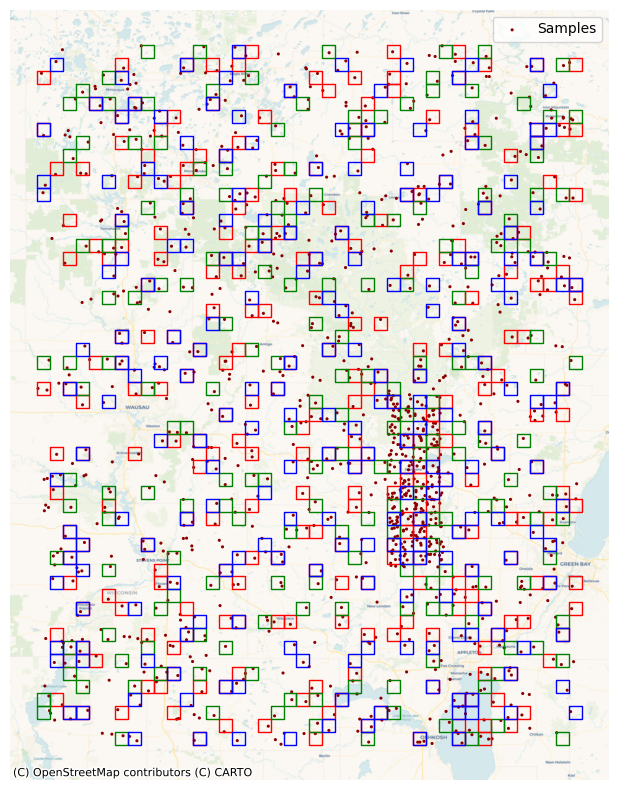

In [17]:
fig, ax = plt.subplots(figsize=(7, 8), dpi=100)
df.plot(color="darkred", ec="none", markersize=5, label="Samples", legend=True, ax=ax)
colors = ["red", "green", "blue"]

qt = pygrts.QuadTree(df, force_square=True)
qt.split_recursive(max_length=5_000)
for i, splits in enumerate(qt.split_kfold(n_splits=3, samples_per_grid=int(1e9), random_state=100)):
    splits.test.grid_df.plot(color="none", ec=colors[i], lw=1, label="Test", ax=ax)

cx.add_basemap(
    ax,
    crs=df.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=10,
)
ax.legend()
ax.axis("off")
plt.tight_layout()